In [1]:
%reload_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from statistics import mean
from statistics import stdev

#Now to implement q learning and variants on the above market environment
import sys
if "../" not in sys.path:
  sys.path.append("../") 

from TD import GeneralQ, ExperienceQ, DynaQ 
from FA.model import TabularModel 
from Tabular import ExpTabAgent
from lib.envs.market import Market
from lib.envs.market2 import Market2
from lib.graphs import make_agent_graphs

from lib.sim_prices import make_prices
from lib.sim_prices2 import make_prices2
from lib.execute_strat import execute_strat
from lib.execute_strat2 import execute_strat2
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step



import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (20,5)

import warnings
warnings.filterwarnings("ignore")

import os
path=os.getcwd()

%matplotlib inline


In [10]:
#################################################
#Set parameters
mu =0.05
rf = 0.04
sigma = 0.028
M = 250
time_periods = M
T = 1.0
dt = T/M
utes = 15
u_star = np.linspace(-10,25, utes) #this is specific to the above parameters

#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0
kappa = 0.007


'\n#Set parameters\nmu =0.11 #save these paramters mu 0.11, rf 0.10, sigma 0.028\nrf = 0.10\nsigma = 0.028\nsigma = 0.045\n\nM = 20 #so 20 time periods or 50 still works...just longer to train and run, u_star = np.linspace(-10,25, utes)\n\ntime_periods = M\nT = 1.0\ndt = T/M\nutes = 15\nu_star = np.linspace(-10,25, utes) #this is specific to the above parameters\nu_star = np.linspace(-10,10, utes)\n\n#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided\n#wealth starts at 100\nS0 = 1\nB0 = 1\nX0 = 100\nwealth = X0\n'

In [9]:
def train_agent(kappa, model, episodes, egreedy=0.1, exprep=0, learning_rate=0.25, gamma=0.95):
    #main function to train the currently q learning tabular agents
    
    wealth = 100.0
    time_periods = M #from earlier on in the code

    utilities_mod = []
    rewards_mod = []
    log_rewards_mod = []
    wealth_episodes = []
    #step_prop = []
    rsum = 0
    log_rsum = 0

    number_of_actions = utes #again from earlier in the code  
    number_of_states = 200 #when adjusting kappa I ran out of states

    start_state = int(wealth/10) #this is tied to wealth/ 10
    state =start_state #try int wealth for states
    
    episodes = episodes #500k worked well? as did 1m
    Mark = Market(kappa, episodes, time_periods, mu, rf, sigma) #parameters from earlier
    
    if model==1:
        #Q learning no tabular model
        SARSA = False
        double = False
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=learning_rate) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        
    elif model==2:
        #Double Q learning no tabular model
        SARSA = False
        double = True
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=learning_rate) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        
    for i_episode in range(episodes-1):
        state = start_state

        while True:    
            prop = u_star[action]
            #reward, d, new_state, dx, done = Mark.step((prop, wealth))

            reward, log_reward, _, _, dx, done = Mark.step((prop, wealth))
            

            wealth += dx
            new_state = int(wealth/10)

            action = agent.step(reward, gamma, new_state) #see difference between reward and log reward

            #Q[state, action] = reward + gamma * torch.max(Q[new_state])
            #Q[state, action] = (1 - learning_rate) * Q[state, action] \
            #    + learning_rate * (reward + gamma * torch.max(Q[new_state])) #this is a simple torch implementation
            rsum += reward
            log_rsum += log_reward 
            state = new_state
            #step_prop.append(prop)

            if done:
                state = start_state
                agent._s = state

                action = agent.behaviour_policy(agent._q[state]) #if dyna
                    
                wealth_episodes.append(wealth)
                utilities_mod.append(np.log(wealth))
                rewards_mod.append(rsum)
                log_rewards_mod.append(log_rsum)
                #mean_prop.append(step_prop)
                rsum = 0
                log_rsum = 0
                wealth = 100.0
                break 
    
    #store the q_values for later testing
    q_name = str(model)+'epi'+str(episodes)+'kap'+str(kappa*1000)+'egr'+str(egreedy)+'lr'+str(learning_rate)+'gam'+str(gamma)
    #q_name = 'LogUteLowVol'+str(model)+'epi'+str(episodes)+'er'+str(exprep) #+'kappa'+str(kappa*1000)
    
    filename = 'test_other_2/'+q_name
    np.save(filename, agent.q_values)
    
    #print(agent.q_values)
    print(q_name + " last 2,000 rewards mean",np.mean(np.array(rewards_mod)[-2000:]))
    print(q_name + " last 2,000 rewards mean",np.mean(np.array(log_rewards_mod)[-2000:]))
    
    return agent.q_values, utilities_mod, rewards_mod, wealth_episodes,log_rewards_mod


# Plot of parameter decay

In [1]:
eps_start=1
eps_end=0.03

0.05

In [2]:
plt.rcParams["figure.figsize"] = (12,5)
plt.plot([eps_end+(eps_start-eps_end)**(x*0.05) for x in range(100000)])
plt.xlabel("Episode")
plt.ylabel("Hyperparameter")

NameError: name 'plt' is not defined

# Plot leverage ratios over time

In [ ]:
"""plt.plot(np.mean(np.array(prop_list[0]).reshape(episodes-1,-1),0), label='single'+' - kappa=0')
plt.plot(np.mean(np.array(prop_list[2]).reshape(episodes-1,-1),0), label='double'+' - kappa=0')
plt.legend()
plt.show()
plt.plot(np.mean(np.array(prop_list[1]).reshape(episodes-1,-1),0), label='single'+' - kappa=0.007')
plt.plot(np.mean(np.array(prop_list[3]).reshape(episodes-1,-1),0), label='double'+' - kappa=0.007')
plt.legend()
plt.show()
#plt.plot(np.mean(np.array(prop_mod_2).reshape((M+1)*50,-1),0), label='model'+str(m)+'kappa'+str(kappa))
#plt.legend()
#plt.show()"""

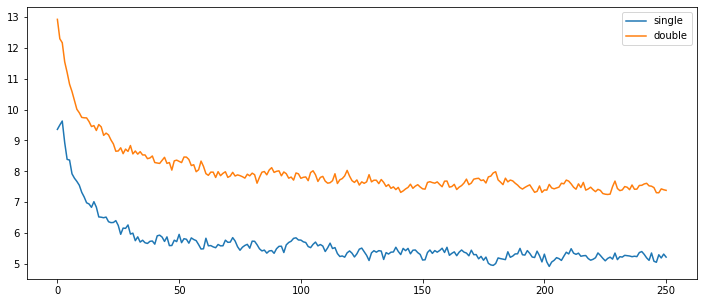

In [ ]:
"""plt.rcParams["figure.figsize"] = (12,5)
#plt.plot(np.mean(np.array(prop_list[0]).reshape(episodes-1,-1),0), label='single'+' - kappa=0')
#plt.plot(np.mean(np.array(prop_list[2]).reshape(episodes-1,-1),0), label='double'+' - kappa=0')
#plt.legend()
#plt.show()
plt.plot(np.mean(np.array(prop_list[1]).reshape(episodes-1,-1),0), label='single')
plt.plot(np.mean(np.array(prop_list[3]).reshape(episodes-1,-1),0), label='double')
plt.legend()
plt.show()
#plt.plot(np.mean(np.array(prop_mod_2).reshape((M+1)*50,-1),0), label='model'+str(m)+'kappa'+str(kappa))
#plt.legend()
#plt.show()"""

# Find best merton action

In [18]:
num_sims =100000
S, B, utility, means, variances = make_prices(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

#if we know the answer is log utility and 
#we know that we have gbm then we can simulate to
#see if our best action is close to the optimal ratio
#according to merton's formula

#we need this to compare the merton strategy to our learned agent
best_action = np.argmax(utility)
merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
print(merton_ratio, best_action)

27.760016372625135
38.885881732966375
54.22726415586837
75.28618221991532
104.06442577901814
77.62338626016238
57.59343205125963
42.50410246441171
31.19986836124705
22.77845487292093
16.53978894044099
11.944102310352566
8.577832826185695
6.126096179886862
4.35063696589037
12.755102040816327 9


# Design: parameter search

In [17]:
plt.rcParams["figure.figsize"] = (6,5)
path=os.getcwd()
files = os.listdir(path+'/test_other/')

par_search = []


for file in files:
    Q = np.load(path+'/test_other/'+file)
    print(file)
    results=execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
                                                            'Agent', q_values=Q, episodes=10001,
                                                            time_periods=time_periods, wealth=wealth)
    par_search.append(results)
    #all_models_dict=dict(zip(q_tables, all_models))

2epi5001kap7.0egr0.15lr0.05gam0.9.npy
2epi5001kap7.0egr0.1lr0.25gam0.9.npy
2epi5001kap7.0egr0.1lr0.15gam0.85.npy
2epi5001kap7.0egr0.1lr0.15gam0.95.npy
2epi5001kap7.0egr0.15lr0.25gam0.9.npy
2epi5001kap7.0egr0.1lr0.05gam0.9.npy
2epi5001kap7.0egr0.15lr0.05gam0.95.npy
2epi5001kap7.0egr0.2lr0.05gam0.95.npy
2epi5001kap7.0egr0.2lr0.15gam0.9.npy
2epi5001kap7.0egr0.15lr0.1gam0.9.npy
2epi5001kap7.0egr0.1lr0.25gam0.95.npy
2epi5001kap7.0egr0.1lr0.25gam0.85.npy
2epi5001kap7.0egr0.2lr0.05gam0.85.npy
2epi5001kap7.0egr0.15lr0.05gam0.85.npy
2epi5001kap7.0egr0.15lr0.25gam0.95.npy
2epi5001kap7.0egr0.2lr0.25gam0.95.npy
1epi5001kap7.0egr0.15lr0.1gam0.9.npy
2epi5001kap7.0egr0.1lr0.05gam0.95.npy
2epi5001kap7.0egr0.1lr0.05gam0.85.npy
2epi5001kap7.0egr0.2lr0.25gam0.9.npy
2epi5001kap7.0egr0.15lr0.15gam0.9.npy
2epi5001kap7.0egr0.2lr0.25gam0.85.npy
2epi5001kap7.0egr0.15lr0.25gam0.85.npy
2epi5001kap7.0egr0.15lr0.15gam0.85.npy
2epi5001kap7.0egr0.2lr0.15gam0.85.npy
2epi5001kap7.0egr0.1lr0.15gam0.9.npy
2epi5001kap7.0

In [22]:
model_results=pd.DataFrame({'model':files})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]
sharpe_list=[]
sortino_list=[]
negative_std_step_list=[]
wealth_list=[]
for i, file in zip(range(len(par_search)),files):
    #sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
    avg_list.append(mean(par_search[i][0]))
    mv_util.append(mean(par_search[i][1]))
    avg_step_list.append(mean(par_search[i][2]))
    #std_step_list.append(stdev(all_models_1[i][2]))
    #negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_1[i][2]))))
    sharpe_list.append(100*mean([x-100-rf*100 for x in par_search[i][3]])/stdev(par_search[i][3]))
    wealth_list.append(mean(par_search[i][3]))
    #sortino_list.append(100*mean([x-100-rf*100 for x in par_search[i][3]])/stdev(list(filter(lambda x: x < 0, [x-100-rf*100 for x in par_search[i][3]]))))
    #plt.legend()
    #plt.show()
model_results['log utility']=avg_list
model_results['MV utility']=mv_util
#model_results['Sharpe']=[x-100/y for x,y in zip(avg_step_list,std_step_list)]
#model_results['Sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['Sharpe']=sharpe_list
#model_results['Sortino']=sortino_list
model_results['Wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results=model_results.sort_values(by='MV utility', ascending=False)
#model_results=model_results.round(3)[1:].drop([24])
model_results['model']=model_results['model'].str.replace('2epi5001kap7.0',"").str.replace('.npy',"")
print(model_results.set_index('model').round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  log utility &  MV utility &  Sharpe &   Wealth \\
model                            &              &             &         &          \\
\midrule
egr0.15lr0.05gam0.9              &        4.696 &      12.352 &  32.269 &  123.563 \\
egr0.2lr0.05gam0.95              &        4.697 &      11.861 &  31.301 &  119.089 \\
egr0.1lr0.15gam0.95              &        4.696 &      10.905 &  29.662 &  118.587 \\
egr0.2lr0.15gam0.9               &        4.685 &      10.639 &  29.961 &  121.653 \\
egr0.1lr0.05gam0.95              &        4.692 &      10.631 &  28.235 &  116.668 \\
egr0.2lr0.05gam0.9               &        4.675 &       8.978 &  28.165 &  112.993 \\
egr0.15lr0.05gam0.95             &        4.679 &       8.796 &  26.905 &  113.164 \\
egr0.15lr0.25gam0.85             &        4.667 &       7.598 &  22.984 &  111.872 \\
egr0.15lr0.15gam0.95             &        4.651 &       7.512 &  22.360 &  117.588 \\
egr0.15lr0.05gam0.85             &        4

# Experiment 1: MV vs EU

In [22]:
def train_agent(kappa, model, episodes, egreedy=0.1, exprep=0, learning_rate=0.25, gamma=0.95, meanvar=True):
    #main function to train the currently q learning tabular agents
    
    wealth = 100.0
    time_periods = M #from earlier on in the code

    utilities_mod = []
    rewards_mod = []
    log_rewards_mod = []
    wealth_episodes = []
    step_prop = []
    rsum = 0
    log_rsum = 0

    number_of_actions = utes #again from earlier in the code  
    number_of_states = 200 #when adjusting kappa I ran out of states

    start_state = int(wealth/10) #this is tied to wealth/ 10
    state =start_state #try int wealth for states
    
    episodes = episodes #500k worked well? as did 1m
    Mark = Market(kappa, episodes, time_periods, mu, rf, sigma) #parameters from earlier
    
    if model==1:
        #Q learning no tabular model
        SARSA = False
        double = False
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=learning_rate) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        
    elif model==2:
        #Double Q learning no tabular model
        SARSA = False
        double = True
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=learning_rate) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        

    for i_episode in range(episodes-1):
        state = start_state

        while True:    
            prop = u_star[action]
            #reward, d, new_state, dx, done = Mark.step((prop, wealth))

            reward, log_reward, _, _, dx, done = Mark.step((prop, wealth))
            

            wealth += dx
            new_state = int(wealth/10)
            if meanvar:
                action = agent.step(reward, gamma, new_state) #see difference between reward and log reward
            else:
                action = agent.step(log_reward, gamma, new_state) #see difference between reward and log reward

            #Q[state, action] = reward + gamma * torch.max(Q[new_state])
            #Q[state, action] = (1 - learning_rate) * Q[state, action] \
            #    + learning_rate * (reward + gamma * torch.max(Q[new_state])) #this is a simple torch implementation
            rsum += reward
            log_rsum += log_reward 
            state = new_state
            step_prop.append(prop)

            if done:
                state = start_state
                agent._s = state
                action = agent.behaviour_policy(agent._q[state]) #if dyna
                    
                wealth_episodes.append(wealth)
                utilities_mod.append(np.log(wealth))
                rewards_mod.append(rsum)
                log_rewards_mod.append(log_rsum)
                #mean_prop.append(step_prop)
                rsum = 0
                log_rsum = 0
                wealth = 100.0
                break 
    
    #store the q_values for later testing
    q_name = str(model)+'epi'+str(episodes)+'meanvar'+str(meanvar)
    #q_name = 'LogUteLowVol'+str(model)+'epi'+str(episodes)+'er'+str(exprep) #+'kappa'+str(kappa*1000)
    
    filename = 'experiment_1_2/'+q_name
    np.save(filename, agent.q_values)
    
    #print(agent.q_values)
    print(q_name + " last 2,000 rewards mean",np.mean(np.array(rewards_mod)[-2000:]))
    print(q_name + " last 2,000 rewards mean",np.mean(np.array(log_rewards_mod)[-2000:]))
    
    return agent.q_values, utilities_mod, rewards_mod, wealth_episodes,log_rewards_mod


In [30]:
for e in [100000]:
    episodes=e
    for m in range(1,2):
        model = m
        for mv in [True, False]:
            meanvar=mv
            print('model'+str(m),'meanvar'+str(mv))
            Q, utilities_mod, rewards_mod, wealth_episodes, log_rewards_mod= train_agent(kappa, model, episodes, egreedy=0.15, exprep=0, learning_rate=0.05, gamma=0.9, meanvar=meanvar)
            #ut_list.append(utilities_mod)

model1 meanvarTrue
1epi100000meanvarTrue last 2,000 rewards mean 6.956242368919927
1epi100000meanvarTrue last 2,000 rewards mean 0.0584180807585703
model1 meanvarFalse
1epi100000meanvarFalse last 2,000 rewards mean 6.000211586693682
1epi100000meanvarFalse last 2,000 rewards mean 0.048306290121594556


In [27]:
from os import listdir
q_tables=os.listdir(path+'/experiment_1_2/')

all_models_1=[]
for file in q_tables:
    print(file)
    Q=np.load(path+f'/experiment_1_2//{file}')
    results=execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
                                                            'Agent', q_values=Q, episodes=100001,
                                                            time_periods=time_periods, wealth=wealth)
    all_models_1.append(results)
    #all_models_dict=dict(zip(q_tables, all_models))

1epi100000meanvarTrue.npy
1epi100000meanvarFalse.npy


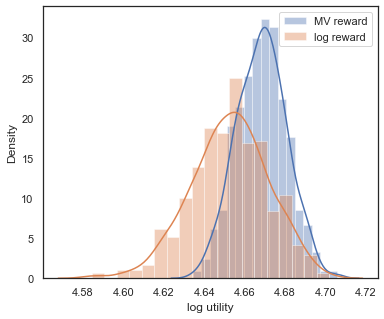

In [32]:
sns.set(rc={'figure.figsize':(6,5)})
sns.set_theme(style="white", palette=None)

for i, file in zip(range(len(all_models_1)),['MV reward','log reward']):
    f=sns.distplot(np.mean(np.array(all_models_1[i][0]).reshape(200,-1),0), label=file)
    f.set(xlabel='log utility')
    plt.legend()
    #plt.show()

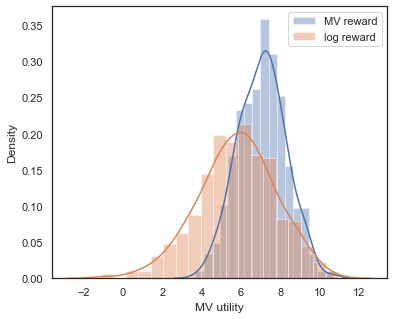

In [33]:
sns.set(rc={'figure.figsize':(6,5)})
sns.set_theme(style="white", palette=None)

for i, file in zip(range(len(all_models_1)),['MV reward','log reward']):
    f=sns.distplot(np.mean(np.array(all_models_1[i][1]).reshape(200,-1),0), label=file)
    f.set(xlabel='MV utility')
    plt.legend()
    #plt.show()

In [28]:
model_results=pd.DataFrame({'model':['MV reward','log reward']})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]
sharpe_list=[]
sortino_list=[]
negative_std_step_list=[]
wealth_list=[]
for i, file in zip(range(len(all_models_1)),q_tables):
    #sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
    avg_list.append(mean(all_models_1[i][0]))
    mv_util.append(mean(all_models_1[i][1]))
    avg_step_list.append(mean(all_models_1[i][2]))
    #std_step_list.append(stdev(all_models_1[i][2]))
    #negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_1[i][2]))))
    sharpe_list.append(100*mean([x-100-rf*100 for x in all_models_1[i][3]])/stdev(all_models_1[i][3]))
    wealth_list.append(mean(all_models_1[i][3]))
    sortino_list.append(100*mean([x-100-rf*100 for x in all_models_1[i][3]])/stdev(list(filter(lambda x: x < 0, [x-100-rf*100 for x in all_models_1[i][3]]))))
    #plt.legend()
    #plt.show()
model_results['log utility']=avg_list
model_results['MV utility']=mv_util
#model_results['Sharpe']=[x-100/y for x,y in zip(avg_step_list,std_step_list)]
#model_results['Sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['Sharpe']=sharpe_list
model_results['Sortino']=sortino_list
model_results['Wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results
#model_results.set_index('model').round(3).to_latex()

,model,log utility,MV utility,Sharpe,Sortino,Wealth
0,MV reward,4.668597,7.082520,24.204236,45.126428,107.962214
1,log reward,4.653353,5.864995,16.466160,56.377729,108.319096


In [29]:
print(model_results.set_index('model').round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  log utility &  MV utility &  Sharpe &  Sortino &   Wealth \\
model      &              &             &         &          &          \\
\midrule
MV reward  &        4.669 &       7.083 &  24.204 &   45.126 &  107.962 \\
log reward &        4.653 &       5.865 &  16.466 &   56.378 &  108.319 \\
\bottomrule
\end{tabular}



# Experiment 2: single vs double

## Learning rate: 0.15

In [5]:
from os import listdir
q_tables=os.listdir(path+'/experiment_2.1/')

all_models_2_1=[]
for file in q_tables:
    print(file)
    Q=np.load(path+f'/experiment_2.1//{file}')
    results=execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
                                                            'Agent', q_values=Q, episodes=10001,
                                                            time_periods=time_periods, wealth=wealth)
    all_models_2_1.append(results)
    #all_models_dict=dict(zip(q_tables, all_models))

1epi100001kap7.0egr0.15lr0.1gam0.9.npy
2epi100001kap7.0egr0.15lr0.1gam0.9.npy


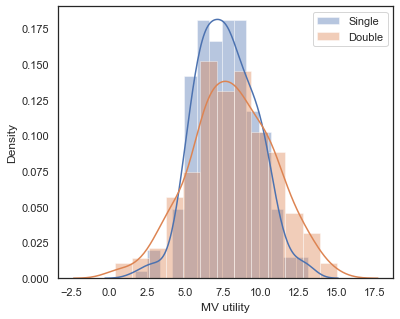

In [37]:
sns.set(rc={'figure.figsize':(6,5)})
sns.set_theme(style="white", palette=None)

for i, file in zip(range(len(all_models_2_1)),['Single','Double']):
    f=sns.distplot(np.mean(np.array(all_models_2_1[i][1]).reshape(200,-1),0), label=file)
    f.set(xlabel='MV utility')
    plt.legend()
    #plt.show()

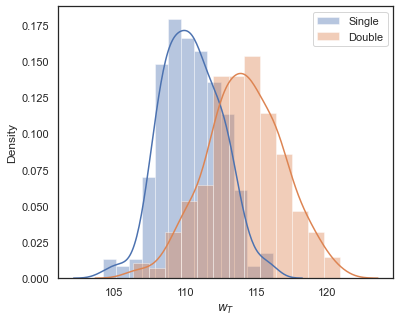

In [38]:
sns.set(rc={'figure.figsize':(6,5)})
sns.set_theme(style="white", palette=None)

for i, file in zip(range(len(all_models_2_1)),['Single','Double']):
    f=sns.distplot(np.mean(np.array(all_models_2_1[i][3]).reshape(200,-1),0), label=file)
    f.set(xlabel=r'$w_T$')
    plt.legend()
    #plt.show()

In [40]:
q_tables

['1epi100001kap7.0egr0.15lr0.1gam0.9.npy',
 '2epi100001kap7.0egr0.15lr0.1gam0.9.npy']

In [6]:
model_results=pd.DataFrame({'model':['Single','Double']})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]
sharpe_list=[]
sortino_list=[]
negative_std_step_list=[]
wealth_list=[]
for i, file in zip(range(len(all_models_2_1)),q_tables):
    #sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
    avg_list.append(mean(all_models_2_1[i][0]))
    mv_util.append(mean(all_models_2_1[i][1]))
    avg_step_list.append(mean(all_models_2_1[i][2]))
    #std_step_list.append(stdev(all_models_1[i][2]))
    #negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_1[i][2]))))
    sharpe_list.append(100*mean([x-100-rf*100 for x in all_models_2_1[i][3]])/stdev(all_models_2_1[i][3]))
    wealth_list.append(mean(all_models_2_1[i][3]))
    sortino_list.append(100*mean([x-100-rf*100 for x in all_models_2_1[i][3]])/stdev(list(filter(lambda x: x < 0, [x-100-rf*100 for x in all_models_2_1[i][3]]))))
    #plt.legend()
    #plt.show()
model_results['log utility']=avg_list
model_results['MV utility']=mv_util
#model_results['Sharpe']=[x-100/y for x,y in zip(avg_step_list,std_step_list)]
#model_results['Sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['Sharpe']=sharpe_list
model_results['Sortino']=sortino_list
model_results['Wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results
#model_results.set_index('model').round(3).to_latex()

,model,log utility,MV utility,Sharpe,Sortino,Wealth
0,Single,4.672920,7.534946,21.471486,81.767921,110.237181
1,Double,4.659107,8.158993,25.886306,48.201098,114.185874


In [7]:
print(model_results.set_index('model').round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  log utility &  MV utility &  Sharpe &  Sortino &   Wealth \\
model  &              &             &         &          &          \\
\midrule
Single &        4.673 &       7.535 &  21.471 &   81.768 &  110.237 \\
Double &        4.659 &       8.159 &  25.886 &   48.201 &  114.186 \\
\bottomrule
\end{tabular}



# Experiment 3: Decreasing alpha

## decreasing parameters

In [50]:
def train_agent_dec_a(kappa, model, episodes, start_eps=1, end_eps=0.03, start_lr=1, end_lr=0.01, gamma=0.9):
    #main function to train the currently q learning tabular agents
    
    wealth = 100.0
    time_periods = M #from earlier on in the code

    utilities_mod = []
    rewards_mod = []
    log_rewards_mod = []
    wealth_episodes = []
    step_prop = []
    rsum = 0
    log_rsum = 0

    number_of_actions = utes #again from earlier in the code  
    number_of_states = 200 #when adjusting kappa I ran out of states

    start_state = int(wealth/10) #this is tied to wealth/ 10
    state =start_state #try int wealth for states
    
    episodes = episodes #500k worked well? as did 1m
    Mark = Market(kappa, episodes, time_periods, mu, rf, sigma) #parameters from earlier
    
    if model==1:
        #Q learning no tabular model
        SARSA = False
        double = False
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=start_lr) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        
    elif model==2:
        #Double Q learning no tabular model
        SARSA = False
        double = True
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=start_lr) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        

    for i_episode in range(episodes-1):
        state = start_state

        while True:    
            prop = u_star[action]
            #reward, d, new_state, dx, done = Mark.step((prop, wealth))

            reward, log_reward, _, _, dx, done = Mark.step((prop, wealth))
            

            wealth += dx
            new_state = int(wealth/10)
            decay_rate=0.00002
            learning_rate = end_lr+(start_lr-end_lr)*math.exp(-1*i_episode*decay_rate)
            egreedy = end_eps+(start_eps-end_eps)*math.exp(-1*i_episode*decay_rate)

            action = agent.step_alpha(reward, gamma, new_state, learning_rate, egreedy) #see difference between reward and log reward
            #Q[state, action] = reward + gamma * torch.max(Q[new_state])
            #Q[state, action] = (1 - learning_rate) * Q[state, action] \
            #    + learning_rate * (reward + gamma * torch.max(Q[new_state])) #this is a simple torch implementation
            rsum += reward
            log_rsum += log_reward 
            state = new_state
            step_prop.append(prop)
            

            if done:
                state = start_state
                agent._s = state

                if model == 5 or model == 6 :
                    agent._last_action = agent.behaviour(state)
                else:
                    action = agent.behaviour_policy(agent._q[state]) #if dyna
                    
                wealth_episodes.append(wealth)
                utilities_mod.append(np.log(wealth))
                rewards_mod.append(rsum)
                log_rewards_mod.append(log_rsum)
                #mean_prop.append(step_prop)
                rsum = 0
                log_rsum = 0
                wealth = 100.0
                break 
    
    #store the q_values for later testing
    q_name = str(model)+'epi'+str(episodes)+'kap'+str(kappa*1000)+'egr'+str(egreedy)+'gam'+str(gamma)
    #q_name = 'LogUteLowVol'+str(model)+'epi'+str(episodes)+'er'+str(exprep) #+'kappa'+str(kappa*1000)
    
    filename = 'experiment_exp_decay/'+q_name
    np.save(filename, agent.q_values)
    
    #print(agent.q_values)
    print(q_name + " last 2,000 rewards mean",np.mean(np.array(rewards_mod)[-2000:]))
    print(q_name + " last 2,000 rewards mean",np.mean(np.array(log_rewards_mod)[-2000:]))
    
    return agent.q_values, utilities_mod, rewards_mod, wealth_episodes,log_rewards_mod, step_prop


In [53]:
#51 minutes to run
train_agent_dec_a(kappa,model=2, episodes=200001, start_eps=1, end_eps=0.03, start_lr=1, end_lr=0.01, gamma=0.9)

2epi200001kap7.0egr0.04776652504901985gam0.9 last 2,000 rewards mean 8.517611635458655
2epi200001kap7.0egr0.04776652504901985gam0.9 last 2,000 rewards mean 0.06425313990641068


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.0186385 , -0.17187842,  0.022815  , ..., -0.40971484,
         -0.23450416, -0.4502211 ],
        [-1.56632177, -1.19168816, -1.3769385 , ..., -1.11308202,
         -1.13339406, -1.49622247],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 [5.024522510311517,
  4.355834169738931,
  4.831714746898355,
  5.069424384884799,
  4.44066919256611,
  5.4977526707260775,
  4.113380081014989,
  4.202260837910134,
  4.689967467435198,
  4.445857854919781,
  4.607018663193602,
  5.652100905010755,
  5.109384936091689,
  4.672378240756205,
  5.138798374045451,
  4.511623013898654,
  5.130721458163224,
  4.458942243194

In [14]:
#3.5 minutes for 50,000 episodes and 2 models
from os import listdir
q_tables=os.listdir(path+'/experiment_3.1/')

all_models_3=[]
for file in q_tables:
    print(file)
    Q=np.load(path+f'/experiment_3.1/{file}')
    results=execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
                                                            'Agent', q_values=Q, episodes=30001,
                                                            time_periods=time_periods, wealth=wealth)
    all_models_3.append(results)
    #all_models_dict=dict(zip(q_tables, all_models))

2epi200001kap7.0egr0.04776652504901985gam0.9.npy
2epi100001kap7.0egr0.15lr0.05gam0.9.npy


In [15]:
#7 minutes for 50,000 episodes and 2 models
model_results=pd.DataFrame({'model':['Decreasing','Constant']})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]    
sharpe_list=[]
sortino_list=[]
negative_std_step_list=[]
wealth_list=[]
for i, file in zip(range(len(all_models_3)),q_tables):
    #sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
    avg_list.append(mean(all_models_3[i][0]))
    mv_util.append(mean(all_models_3[i][1]))
    avg_step_list.append(mean(all_models_3[i][2]))
    #std_step_list.append(stdev(all_models_1[i][2]))
    #negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_1[i][2]))))
    sharpe_list.append(100*mean([x-100-rf*100 for x in all_models_3[i][3]])/stdev(all_models_3[i][3]))
    wealth_list.append(mean(all_models_3[i][3]))
    sortino_list.append(100*mean([x-100-rf*100 for x in all_models_3[i][3]])/stdev(list(filter(lambda x: x < 0, [x-100-rf*100 for x in all_models_3[i][3]]))))
    #plt.legend()
    #plt.show()
model_results['log utility']=avg_list
model_results['MV utility']=mv_util
#model_results['Sharpe']=[x-100/y for x,y in zip(avg_step_list,std_step_list)]
#model_results['Sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['Sharpe']=sharpe_list
model_results['Sortino']=sortino_list
model_results['Wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results
#model_results.set_index('model').round(3).to_latex()

,model,log utility,MV utility,Sharpe,Sortino,Wealth
0,Decreasing,4.689241,10.414224,27.357147,105.943234,117.165104
1,Constant,4.647174,4.507214,7.742718,18.347831,105.041405


In [16]:
#30 sec
print(model_results.set_index('model').round(3).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  log utility &  MV utility &  Sharpe &  Sortino &   Wealth \\
model      &              &             &         &          &          \\
\midrule
Decreasing &        4.689 &      10.414 &  27.357 &  105.943 &  117.165 \\
Constant   &        4.647 &       4.507 &   7.743 &   18.348 &  105.041 \\
\bottomrule
\end{tabular}



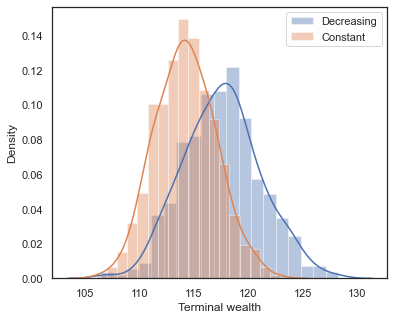

In [58]:
#2 minutes
sns.set(rc={'figure.figsize':(6,5)})
sns.set_theme(style="white", palette=None)

for i, file in zip(range(len(all_models_3)),['Decreasing','Constant']):
    f=sns.distplot(np.mean(np.array(all_models_3[i][3]).reshape(200,-1),0), label=file)
    f.set(xlabel=r'Terminal wealth')
    plt.legend()
    #plt.show()

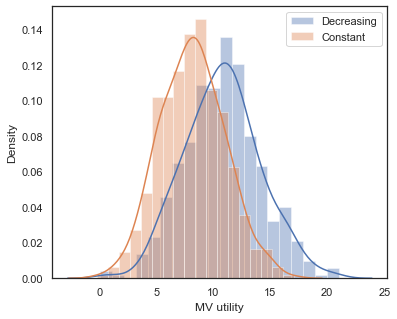

In [59]:
#12 sec
sns.set(rc={'figure.figsize':(6,5)})
sns.set_theme(style="white", palette=None)

for i, file in zip(range(len(all_models_3)),['Decreasing','Constant']):
    f=sns.distplot(np.mean(np.array(all_models_3[i][1]).reshape(200,-1),0), label=file)
    f.set(xlabel=r'MV utility')
    plt.legend()
    #plt.show()

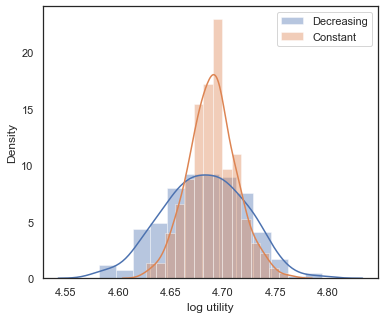

In [10]:
#2 minutes
sns.set(rc={'figure.figsize':(6,5)})
sns.set_theme(style="white", palette=None)

for i, file in zip(range(len(all_models_3)),['Decreasing','Constant']):
    f=sns.distplot(np.mean(np.array(all_models_3[i][0]).reshape(200,-1),0), label=file)
    f.set(xlabel=r'log utility')
    plt.legend()
    #plt.show()

# colour-visualize q-tables

In [1]:
def _color_red_or_green(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

In [75]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
import numpy as np

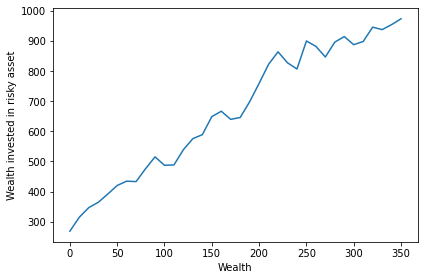

In [214]:
plt.plot(np.linspace(0,350,36),np.convolve(y*x, np.ones((15,))/15, mode='valid'))
plt.xlabel("Wealth")
plt.ylabel("Wealth invested in risky asset")
plt.tight_layout()
plt.show()

2epi200001kap9.0egr0.04776652504901985gam0.9.npy


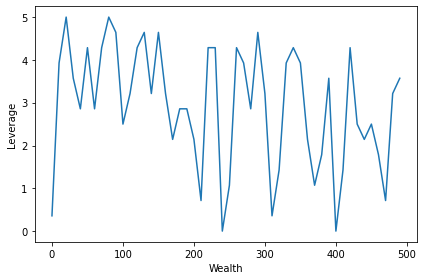

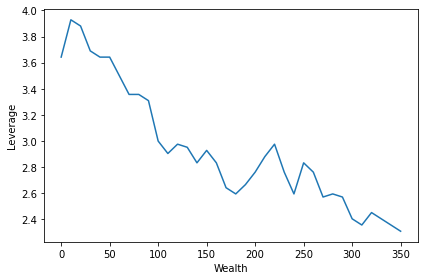

In [205]:
utes = 15 #choose 21 to get nice round leverage ratios
u_star = np.linspace(0,5, utes) #this is specific to the above parameters
q_tables=os.listdir(path+'/experiment_5_8/')
for file in q_tables:
    print(file)
    Q=np.load(path+f'/experiment_5_8/{file}')

    q_df=pd.DataFrame(Q)
    q_df.columns=u_star

    x=q_df.head(50).idxmax(axis=1).index*10
    y=q_df.head(50).idxmax(axis=1).values

    X_Y_Spline = make_interp_spline(x, y)
    
    # Returns evenly spaced numbers
    # over a specified interval.
    X_ = np.linspace(x.min(), x.max(), 1000)
    Y_ = X_Y_Spline(X_)

    m,b = np.polyfit(x, y, 1)
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef)
    #plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k')
    
    # Plotting the Graph
    #plt.plot(X_, Y_)
    #plt.title("Plot Smooth Curve")
    plt.plot(x,y)
    plt.xlabel("Wealth")
    plt.ylabel("Leverage")
    plt.tight_layout()
    plt.show()

    plt.plot(np.linspace(0,350,36),np.convolve(y, np.ones((15,))/15, mode='valid'))
    plt.xlabel("Wealth")
    plt.ylabel("Leverage")
    plt.tight_layout()
    plt.show()

# plot decay rate

In [9]:
start_eps=1
end_eps=0.01
start_lr=1
end_lr=0.005

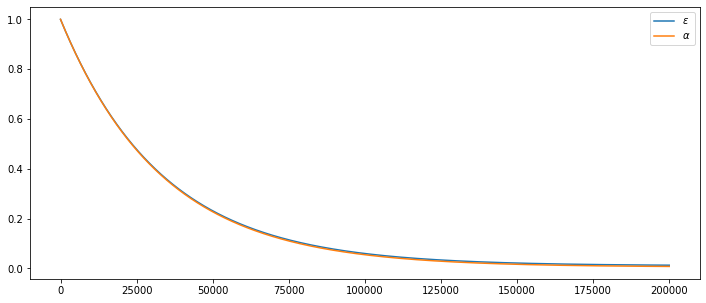

In [17]:
plt.rcParams["figure.figsize"] = (12,5)
plt.plot([end_eps+(start_eps-end_eps)*math.exp(-1*x*0.00003) for x in range(200000)], label=r'$\epsilon$')
plt.plot([end_lr+(start_lr-end_lr)*math.exp(-1*x*0.00003) for x in range(200000)], label=r'$\alpha$')
plt.legend()

# Experiment 4: comparison to Merton and random agent

# Create tables for Merton and Random agent

In [66]:
#get the random and optimal agent values
#run the various baseline graphs pre agent
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand, log_rewards_test_rand = execute_strat2(kappa,mu, 
                                                                      rf, sigma, utes,u_star,best_action, 'Random', 
                                                                      time_periods=time_periods, wealth=wealth, episodes=50001)

In [67]:
log_util_rand = mean(utilities_test_rand)
mv_util_rand = mean(rewards_test_rand)
wealth_rand = mean(wealth_test_rand)
avg_step_rand = mean(step_rew_rand)
std_step_rand = stdev(step_rew_rand)
neg_std_step_rand = stdev(list(filter(lambda x: x<0, step_rew_rand)))

rand_log_list=['Random',
log_util_rand, 
mv_util_rand, 
avg_step_rand/std_step_rand,
avg_step_rand/neg_std_step_rand,
wealth_rand]

In [69]:

utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best, log_rewards_test_best = execute_strat2(kappa, mu, rf, sigma, 
                                                                      utes, u_star, best_action,'Merton', 
                                                                      time_periods=time_periods, wealth=wealth, episodes=50001)

#block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
#block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)

In [70]:
log_util_best = mean(utilities_test_best)
mv_util_best = mean(rewards_test_best)
wealth_best = mean(wealth_test_best)
avg_step_best = mean(step_rew_best)
std_step_best = stdev(step_rew_best)
neg_std_step_best = stdev(list(filter(lambda x: x<0, step_rew_best)))

best_log_list=['Merton',
log_util_best, 
mv_util_best, 
avg_step_best/std_step_best,
avg_step_best/neg_std_step_best,
wealth_best]

## Table

In [40]:
columns=['Model','log utility','MV utility','Sharpe','Sortino','Wealth']

In [48]:
model_results=pd.DataFrame([rand_log_list, best_log_list], columns=columns)

model_results
model_results.set_index('model').round(3).to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n{} &    log &      mv &  sharpe &  sortino &   wealth \\\\\nmodel  &        &         &         &          &          \\\\\n\\midrule\nRandom &  4.652 &   6.354 &    0.01 &    0.012 &  112.061 \\\\\nMerton &  4.708 &  12.459 &    0.02 &    0.031 &  117.849 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Experiment 5: increase realism

## find first and second order moments from sp500 data

In [15]:
from pandas_datareader import data as wb
from scipy.stats import norm

<AxesSubplot:xlabel='Date'>

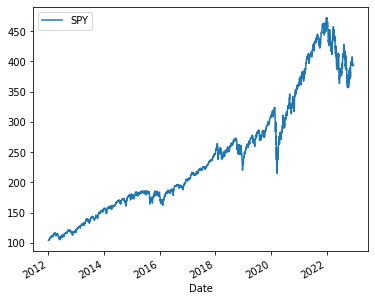

In [16]:
ticker = 'SPY'
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source = 'yahoo', start = '2012-1-1')['Adj Close']
#Plot
data.plot(figsize=(6,5))

Text(0, 0.5, 'Frequency')

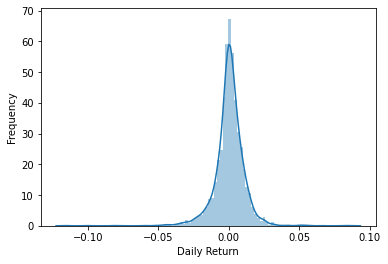

In [17]:
log_returns = np.log(1 + data.pct_change())
#Plot
sns.distplot(log_returns.iloc[1:], bins=100)
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

In [18]:
u = log_returns.mean()
sp500_mu=float(u*250)
sp500_sigma=float(np.sqrt(np.var(log_returns*np.sqrt(250))))

In [20]:
#Set parameters
mu =sp500_mu
rf = 0.0477
sigma = sp500_sigma
M = 250
time_periods = M
T = 1.0
dt = T/M
utes = 21 #choose 21 to get nice round leverage ratios
u_star = np.linspace(0,5, utes) #this is specific to the above parameters

#We will always start with a stock price of 1, bond price of 1, and a time period which will be subdivided
#wealth starts at 100
S0 = 1
B0 = 1
X0 = 100
wealth = X0
kappa = 0.005

#

In [29]:
num_sims =100000
S, B, utility, means, variances = make_prices2(mu, sigma, rf, utes, time_periods, dt, X0, B0,S0, u_star, num_sims)

#if we know the answer is log utility and 
#we know that we have gbm then we can simulate to
#see if our best action is close to the optimal ratio
#according to merton's formula

#we need this to compare the merton strategy to our learned agent
best_action = np.argmax(utility)
merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
print(merton_ratio, best_action)

104.86558487107264
84.53088945144836
67.93955809664368
54.44310053258233
43.49739882149076
34.64741765014148
27.51387850057413
21.78169463154264
17.189976019041747
13.523426604880644
10.60496992799998
8.289453088219785
6.458292712805219
5.014939923930225
3.8810540582967454
2.9932869370465807
2.300590735436758
1.7619729040691514
1.3446311228236854
1.0224099249519438
0.7745284307332416
2.55873284566027 10


In [30]:
def train_agent_dec_a_2(kappa, model, episodes, start_eps=1, end_eps=0.01, start_lr=1, end_lr=0.001, gamma=0.99):
    #main function to train the currently q learning tabular agents
    
    wealth = 100.0
    time_periods = M #from earlier on in the code

    utilities_mod = []
    rewards_mod = []
    log_rewards_mod = []
    wealth_episodes = []
    step_prop = []
    rsum = 0
    log_rsum = 0

    number_of_actions = utes #again from earlier in the code  
    number_of_states = 200 #when adjusting kappa I ran out of states

    start_state = int(wealth/10) #this is tied to wealth/ 10
    state =start_state #try int wealth for states
    
    episodes = episodes #500k worked well? as did 1m
    Mark = Market2(kappa, episodes, time_periods, mu, rf, sigma) #parameters from earlier
    
    if model==1:
        #Q learning no tabular model
        SARSA = False
        double = False
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=start_lr) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        
    elif model==2:
        #Double Q learning no tabular model
        SARSA = False
        double = True
        
        agent = GeneralQ(number_of_states, number_of_actions, state, SARSA, 
                     double, step_size=start_lr) #here eps set to 0.1 anyway
        action = agent.behaviour_policy(agent._q[state])
        

    for i_episode in range(episodes-1):
        state = start_state

        while True:    
            prop = u_star[action]
            #reward, d, new_state, dx, done = Mark.step((prop, wealth))

            reward, log_reward, _, _, dx, done = Mark.step((prop, wealth))
            

            wealth += dx
            new_state = int(wealth/10)
            decay_rate=0.00003
            learning_rate = end_lr+(start_lr-end_lr)*math.exp(-1*i_episode*decay_rate)
            egreedy = end_eps+(start_eps-end_eps)*math.exp(-1*i_episode*decay_rate)

            action = agent.step_alpha(reward, gamma, new_state, learning_rate, egreedy) #see difference between reward and log reward
            #Q[state, action] = reward + gamma * torch.max(Q[new_state])
            #Q[state, action] = (1 - learning_rate) * Q[state, action] \
            #    + learning_rate * (reward + gamma * torch.max(Q[new_state])) #this is a simple torch implementation
            rsum += reward
            #log_rsum += log_reward 
            state = new_state
            #step_prop.append(prop)
            

            if done:
                state = start_state
                agent._s = state

                action = agent.behaviour_policy(agent._q[state]) #if dyna
                    
                wealth_episodes.append(wealth)
                utilities_mod.append(np.log(wealth))
                rewards_mod.append(rsum)
                #log_rewards_mod.append(log_rsum)
                #mean_prop.append(step_prop)
                rsum = 0
                log_rsum = 0
                wealth = 100.0
                break 
    
    #store the q_values for later testing
    q_name = str(model)+'epi'+str(episodes)+'kap'+str(kappa*1000)+'egr'+str(egreedy)+'gam'+str(gamma)
    #q_name = 'LogUteLowVol'+str(model)+'epi'+str(episodes)+'er'+str(exprep) #+'kappa'+str(kappa*1000)
    
    filename = 'experiment_5_9/'+q_name
    np.save(filename, agent.q_values)
    
    #print(agent.q_values)
    print(q_name + " last 5,000 rewards mean",np.mean(np.array(rewards_mod)[-5000:]))
    #print(q_name + " last 5,000 rewards mean",np.mean(np.array(log_rewards_mod)[-5000:]))
    
    return agent.q_values, utilities_mod, rewards_mod, wealth_episodes


In [33]:
# 20 minutes 100,000 episodes (15 leverage options)
# 48 for 200,000 (21 leverage options)
# 400 for 300,000 (and 42 leverage options)
Q, utilities_mod, rewards_mod, wealth_episodes = train_agent_dec_a_2(kappa=0.008,model=2, episodes=200001, start_eps=1, end_eps=0.01, start_lr=1, end_lr=0.001, gamma=0.99)


2epi200001kap8.0egr0.012454038274943636gam0.99 last 5,000 rewards mean 9.429667975425648


In [31]:
# 20 minutes 100,000 episodes (15 leverage options)
# 48 for 200,000 (21 leverage options)
# 400 for 300,000 (and 42 leverage options)
Q, utilities_mod, rewards_mod, wealth_episodes = train_agent_dec_a_2(kappa=0.005,model=2, episodes=200001, start_eps=1, end_eps=0.01, start_lr=1, end_lr=0.001, gamma=0.99)


2epi200001kap5.0egr0.012454038274943636gam0.99 last 5,000 rewards mean 12.369849393777576


In [16]:
# 20 minutes 100,000 episodes (15 leverage options)
# 48 for 200,000 (21 leverage options)
# 400 for 300,000 (and 42 leverage options)
for e in [200001]:
    episodes=e
    for m in range(2,3):
        model = m
        for k in [0.009]:
            kappa=k
            for g in [0.9]:
                gamma=g
                Q, utilities_mod, rewards_mod, wealth_episodes, log_rewards_mod= train_agent_dec_a_2(kappa,model=2, episodes=200001, start_eps=1, end_eps=0.03, start_lr=1, end_lr=0.01, gamma=0.9)


2epi200001kap9.0egr0.04776652504901985gam0.9 last 5,000 rewards mean 4.785242182225529
2epi200001kap9.0egr0.04776652504901985gam0.9 last 5,000 rewards mean 0.0487790733977392


# create table for experiment 5

In [32]:
#3.5 minutes for 50,000 episodes and 2 models
from os import listdir
q_tables=os.listdir(path+'/experiment_5_9/')

all_models_5_1=[]
for file in q_tables:
    print(file)
    Q=np.load(path+f'/experiment_5_9/{file}')
    results=execute_strat2(kappa, mu, rf, sigma, utes, u_star,best_action, 
                                                            'Agent', q_values=Q, episodes=100001,
                                                            time_periods=time_periods, wealth=wealth)
    all_models_5_1.append(results)
    #all_models_dict=dict(zip(q_tables, all_models))

2epi200001kap5.0egr0.012454038274943636gam0.99.npy


In [14]:
model_results=pd.DataFrame({'model':['low_kappa','high_kappa']})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]
negative_std_step_list=[]
wealth_list=[]
for i, file in zip(range(len(all_models_5_1)),q_tables):
    #sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
    avg_list.append(mean(all_models_5_1[i][0]))
    mv_util.append(mean(all_models_5_1[i][1]))
    avg_step_list.append(mean(all_models_5_1[i][2]))
    std_step_list.append(stdev(all_models_5_1[i][2]))
    negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_5_1[i][2]))))
    wealth_list.append(mean(all_models_5_1[i][3]))
    #plt.legend()
    #plt.show()
model_results['avg. log utility']=avg_list
model_results['mean-variance utility']=mv_util
model_results['sharpe']=[x/y for x,y in zip(avg_step_list,std_step_list)]
#model_results['sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results
#model_results.set_index('model').round(3).to_latex()

,model,avg. log utility,mean-variance utility,sharpe,wealth
0,low_kappa,4.665938,1.640187,0.002467,113.973455
1,high_kappa,4.645010,4.063961,11.066509,104.064426


In [13]:
model_results=pd.DataFrame({'model':['Q-learning']})

avg_list=[]
mv_util=[]
avg_step_list=[]
std_step_list=[]
negative_std_step_list=[]
wealth_list=[]
for i, file in zip(range(len(all_models_5_1)),q_tables):
    #sns.distplot(np.mean(np.array(all_models[i][4]).reshape(500,-1),0), label=file)
    avg_list.append(mean(all_models_5_1[i][0]))
    mv_util.append(mean(all_models_5_1[i][1]))
    avg_step_list.append(mean(all_models_5_1[i][2]))
    std_step_list.append(stdev(all_models_5_1[i][2]))
    negative_std_step_list.append(stdev(list(filter(lambda x: x < 0, all_models_5_1[i][2]))))
    wealth_list.append(mean(all_models_5_1[i][3]))
    #plt.legend()
    #plt.show()
model_results['avg. log utility']=avg_list
model_results['mean-variance utility']=mv_util
model_results['sharpe']=[x/y for x,y in zip(avg_step_list,std_step_list)]
model_results['sortino']=[x/y for x,y in zip(avg_step_list,negative_std_step_list)]
model_results['wealth']=wealth_list
#model_results.loc[0]=rand_log_list
#model_results.loc[1]=best_log_list
model_results
#model_results.set_index('model').round(3).to_latex()

,model,avg. log utility,mean-variance utility,sharpe,sortino,wealth
0,Q-learning,4.686772,16.966137,0.016663,0.020938,127.327157


In [63]:
model_results.loc[0]=rand_log_list
model_results.loc[1]=best_log_list
model_results

,model,avg. log utility,mean-variance utility,sharpe,sortino,wealth
0,Random,4.738207,6.146313,0.007220,0.009651,126.449448
1,Merton,4.754651,9.295357,0.011674,0.017176,127.072421


In [62]:
rand_log_list

['Random',
 4.738206850641823,
 6.146312525139473,
 0.007220105881962449,
 0.009650922876703102,
 126.44944771521138]

## try to plot densities

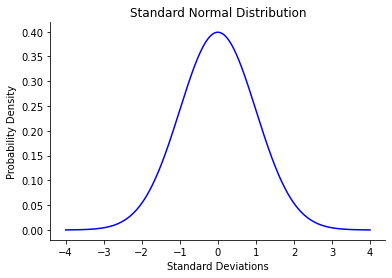

In [22]:
# Library imports
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Defining the x and y variables for the graph
x = np.linspace(-4, 4, 500)
y = stats.norm.pdf(x)

# Plotting
plt.ylabel('Probability Density')
plt.xlabel('Standard Deviations')
plt.title('Standard Normal Distribution')
plt.plot(x, y, color='blue')

# Styling - optional
sns.set_context('notebook')
sns.despine();

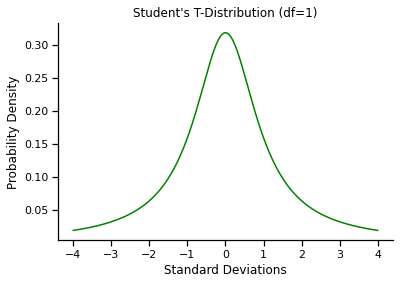

In [23]:
# Library imports
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Defining the degrees of freedom, x, and y variables for the graph
df = 1
x = np.linspace(-4, 4, 500)
y = stats.t.pdf(x, df)

# Plotting
plt.ylabel('Probability Density')
plt.xlabel('Standard Deviations')
plt.title(f'Student\'s T-Distribution (df={df})')
plt.plot(x, y, color='green')

# Styling - optional
sns.set_context('notebook')
sns.despine();

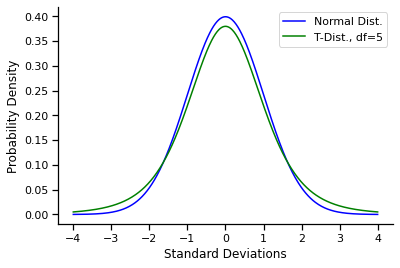

In [33]:
# Library imports
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

# Normal distribution
x = np.linspace(-4, 4, 500)
y = stats.norm.pdf(x)

# T distribution
df = 5
y_t = stats.t.pdf(x, df)

# Plotting
plt.ylabel('Probability Density')
plt.xlabel('Standard Deviations')
plt.plot(x, y, color='blue', label='Normal Dist.')
plt.plot(x, y_t, color='green', label=f'T-Dist., df={df}')
plt.legend()

# Styling - optional
sns.set_context('notebook')
sns.despine();